# Get the DataSet

In [ ]:
import pandas as pd

df_all_data = pd.read_csv('https://raw.githubusercontent.com/mphammer/HammerData/main/IMDB/IMDB%20Dataset.csv')

df_all_data.sample(10)

,review,sentiment
11503,"This is the most boring, pretentious, and stup...",negative
13934,"That's right, you heard me. I am a huge fan of...",negative
32191,Lloyd Bridges as Mike Nelson and his boat were...,positive
7,"This show was an amazing, fresh & innovative i...",negative
40014,"James Cagney, racketeer and political ward hee...",positive
31413,That was great fun! I never read those Chester...,positive
40148,There are moments in the film that are so drea...,positive
34167,A bit quirky and bordering bad taste; but inte...,positive
8597,"Dark Rising is your typical bad, obviously qui...",negative
31820,This was a pathetic movie. The Alien was decen...,negative


# Split Train and Test Data

I read that it's good to split your data early so that you don't look at your Test Data too much and unconsciously learn patterns about it.

Ref: Data Snooping Bias

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_all_data, test_size=0.2)

In [ ]:
print(df_train['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

sentiment
positive    20043
negative    19957
Name: count, dtype: int64
sentiment
negative    5043
positive    4957
Name: count, dtype: int64


# Clean the Sequence

We want to clean up the sentences and convert them into a list of words. This list of words will be the Sequence that we pass into our LSTM model.

Steps:
1. Remove "\<br />" that I saw in many reviews
2. Remove puncutation
3. Make everything lowercase
4. Split on spaces to get a list of words
5. Remove stop words

In [ ]:
test_string = "The man's old uncle Dr. Joe ate all of the <food_name>! #Hangry <br /><br /> blah..."
test_string_saved = test_string

In [ ]:
def remove_br(a_string):
  return a_string.replace("<br />", " ")

test_string = remove_br(test_string)
test_string

"The man's old uncle Dr. Joe ate all of the <food_name>! #Hangry    blah..."

In [ ]:
import string
punctuation_set = set(string.punctuation)

def remove_punctuation(a_string):
  clean_character_array = [character if character not in punctuation_set else "" for character in a_string]
  return "".join(clean_character_array)

test_string = remove_punctuation(test_string)
test_string

'The mans old uncle Dr Joe ate all of the foodname Hangry    blah'

In [ ]:
def to_lower(a_string):
  return a_string.lower()

test_string = to_lower(test_string)
test_string

'the mans old uncle dr joe ate all of the foodname hangry    blah'

In [ ]:
def split_words(a_string):
  return [word for word in a_string.split(" ") if word != ''] # split on spaces and remove if empty string

test_list = split_words(test_string)
test_list

['the',
 'mans',
 'old',
 'uncle',
 'dr',
 'joe',
 'ate',
 'all',
 'of',
 'the',
 'foodname',
 'hangry',
 'blah']

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words('english'))

def no_more_stopwords(a_list):
  return [word for word in a_list if word not in stop_words]

test_list = no_more_stopwords(test_list)
test_list

['mans', 'old', 'uncle', 'dr', 'joe', 'ate', 'foodname', 'hangry', 'blah']

In [ ]:
def clean_string(a_string): # returns a list of tokens
  return no_more_stopwords(split_words(to_lower(remove_punctuation(remove_br(a_string)))))

clean_string(test_string_saved)

['mans', 'old', 'uncle', 'dr', 'joe', 'ate', 'foodname', 'hangry', 'blah']

In [ ]:
df_train['clean_review'] = df_train['review'].apply(lambda review_str: clean_string(review_str))
df_test['clean_review'] = df_test['review'].apply(lambda review_str: clean_string(review_str))

In [ ]:
df_train.head()

,review,sentiment,clean_review
12092,All the pro comments about this movie claim th...,negative,"[pro, comments, movie, claim, movie, balanced,..."
13045,Tears of Kali is an original yet flawed horror...,positive,"[tears, kali, original, yet, flawed, horror, f..."
38989,Warning: contains a spoiler. Corny plot and in...,positive,"[warning, contains, spoiler, corny, plot, many..."
19727,Saw this movie twice at community screenings a...,positive,"[saw, movie, twice, community, screenings, rea..."
9550,Isabelle Huppert must be one of the greatest a...,positive,"[isabelle, huppert, must, one, greatest, actre..."


# Preprocessing: Prepare Data for Training

## Convert Labels

In [ ]:
df_train['sentiment'].value_counts()

df_train['label'] = (df_train['sentiment'] == 'positive') + 0
df_test['label'] = (df_test['sentiment'] == 'positive') + 0

df_train['label']

,label
12092,0
13045,1
38989,1
19727,1
9550,1
...,...
9949,1
23108,0
4397,1
7832,1


## Create Embeddings for Words in the Sequences

We already stated that a Sequence will be a list of words, but we need to convert the words to numerical representations. For this, we will use Word2Vec to create embeddings.

In [ ]:
from gensim.models import Word2Vec

EMBEDDING_SIZE = 50 # all words have the same size embedding vector

all_reviews = df_train['clean_review'].tolist()
all_reviews.extend(df_test['clean_review'].tolist())

w2v_model = Word2Vec(all_reviews, vector_size=EMBEDDING_SIZE)

In [ ]:
w2v_model.wv['movie']

array([ 0.31828904, -0.8868779 ,  1.3738177 ,  1.2184459 ,  0.90348727,
       -0.8043505 , -0.68080163,  0.23262513, -0.91925955,  0.46507916,
        2.1265419 , -0.4203812 ,  0.6851513 ,  1.9406614 ,  2.44906   ,
       -0.01712836,  2.4688804 ,  0.8475711 ,  0.6018288 , -0.5392597 ,
        0.49386418, -1.4467301 ,  1.522605  , -1.4516146 ,  2.1354558 ,
       -1.5341475 ,  0.9359828 ,  3.3123887 ,  0.6991249 , -0.564326  ,
       -2.9011707 , -0.21526068,  2.469162  , -2.224061  , -0.07555475,
       -0.6854777 ,  1.4547677 , -2.2247236 , -1.200595  ,  0.49142864,
        0.81556785,  3.270022  ,  0.01640308, -0.03049554, -0.3370168 ,
        2.0427492 , -0.06241551,  0.69856083, -3.0602958 ,  0.6697606 ],
      dtype=float32)

In [ ]:
# w2v_model.wv['movie']
# w2v_model.wv.key_to_index['computer']
# w2v_model.wv.index_to_key[0]

w2v_model.wv.most_similar('movie', topn=3)

[('film', 0.8750318288803101),
 ('flick', 0.7314739227294922),
 ('movies', 0.7211723923683167)]

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

SEQUENCE_LENGTH = 100 # cap each review to 100 words (tokens)

def convert_sequences_to_tensor(sequences, num_tokens_in_sequence, embedding_size):
  '''
  We want a torch.FloatTensor() of size (num_sequences, num_tokens_in_sequence, embedding_size)
  '''
  num_sequences = len(sequences)
  print((num_sequences, num_tokens_in_sequence, embedding_size))

  data_tensor = torch.zeros((num_sequences, num_tokens_in_sequence, embedding_size))

  for index, review in enumerate(list(sequences)):
    # Create a word embedding for each word in the review (where a review is a sequence)
    truncated_clean_review = review[:num_tokens_in_sequence] # truncate to sequence length limit
    list_of_word_embeddings = [w2v_model.wv[word] if word in w2v_model.wv else [0.0]*embedding_size for word in truncated_clean_review]

    # convert the review to a tensor
    sequence_tensor = torch.FloatTensor(list_of_word_embeddings)

    # add the review to our tensor of data
    review_length = sequence_tensor.shape[0] # (review_length, embedding_size)
    data_tensor[index,:review_length,:] = sequence_tensor

  return data_tensor

In [ ]:
train_data_X = convert_sequences_to_tensor(df_train['clean_review'].to_numpy(), SEQUENCE_LENGTH, EMBEDDING_SIZE)
train_data_y = torch.FloatTensor([int(d) for d in df_train['label'].to_numpy()])

test_data_X = convert_sequences_to_tensor(df_test['clean_review'].to_numpy(), SEQUENCE_LENGTH, EMBEDDING_SIZE)
test_data_y = torch.FloatTensor([int(d) for d in df_test['label'].to_numpy()])

(40000, 100, 50)


<ipython-input-18-3eae154a8606>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  sequence_tensor = torch.FloatTensor(list_of_word_embeddings)


(10000, 100, 50)


In [ ]:
print("Example Sequence:")
print(train_data_X[0])

print("Example Label:")
print(train_data_y[0])

Example Sequence:
tensor([[-0.5401, -0.1672,  0.8391,  ..., -0.8313,  0.3483,  0.1239],
        [ 0.1263,  2.4532,  0.1125,  ..., -2.4811, -1.3203,  0.4051],
        [ 0.3183, -0.8869,  1.3738,  ...,  0.6986, -3.0603,  0.6698],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
Example Label:
tensor(0.)


In [ ]:
train_data = TensorDataset(train_data_X, train_data_y)
test_data = TensorDataset(test_data_X, test_data_y)

In [ ]:
batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Create the Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers, drop_prob=0.7):
    '''
    lstm_input_dim: number of values in an embedding
    '''
    super(LSTMModel,self).__init__()

    self.num_stacked_layers = num_stacked_layers
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(
        input_size = input_size,
        hidden_size = hidden_size,
        num_layers = num_stacked_layers,
        batch_first = True
      )

    self.dropout = nn.Dropout(drop_prob) # randomly sets outputs of a tensor to 0 during training

    self.fc = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    '''
    x -> (batch_size, sequence_size, embedding_size)
    '''
    batch_size = x.size(0)

    # Initialize the cell state and hidden state
    h0 = torch.zeros((self.num_stacked_layers, batch_size, self.hidden_size)).to(device)
    c0 = torch.zeros((self.num_stacked_layers, batch_size, self.hidden_size)).to(device)

    # Call the LSTM
    lstm_out, hidden = self.lstm(x, (h0, c0))

    # contiguous() moves all data into 1 block of memory on the GPU
    # (batch_size, sequence_size, embedding_size) -> (batch_size*sequence_size, embedding_size)
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

    # dropout and fully connected layer
    lstm_out = self.dropout(lstm_out) # Only during training
    fc_out = self.fc(lstm_out)

    # apply the sigmoid function to maps the value to somewhere between 0 and 1
    sigmoid_out = self.sigmoid(fc_out)

    # reshape to be batch_size first - every batch has a value between 0 and 1
    sigmoid_out = sigmoid_out.view(batch_size, -1) # a list of lists with single elements
    sigmoid_out = sigmoid_out[:, -1] # get the output labels as a list

    # return last sigmoid output and hidden state
    return sigmoid_out, hidden

In [ ]:
LSTM_INPUT_SIZE = EMBEDDING_SIZE # size of the embeddings
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_STACKED_LAYERS = 2

lstm_model = LSTMModel(LSTM_INPUT_SIZE, LSTM_HIDDEN_SIZE, LSTM_NUM_STACKED_LAYERS)
lstm_model.to(device)
print(lstm_model)

LSTMModel(
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Training Loop

In [ ]:
import numpy as np

lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
epochs = 15

def accuracy(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
# Training loop
def train_loop(model, train_loader, optimizer, criterion):
  model.train()
  train_accuracy = 0.0
  train_losses = []
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs, h = model(inputs) # Forward pass
    loss = criterion(outputs, labels) # Calculate the loss
    optimizer.zero_grad() # Clear out all previous gradients
    loss.backward() # Calculate new gradients
    optimizer.step() # Update parametres using the gradients

    train_losses.append(loss.item())
    train_accuracy += accuracy(outputs, labels)

  epoch_train_loss = np.mean(train_losses)
  epoch_train_acc = (train_accuracy/len(train_loader.dataset))*100.0
  return (epoch_train_loss, epoch_train_acc)

# Test/Validation Loop
def test_loop(model, test_loader, criterion):
  model.eval()
  test_accuracy = 0.0
  test_losses = []
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs, val_h = model(inputs)
      loss = criterion(outputs, labels)

      test_losses.append(loss.item())
      test_accuracy += accuracy(outputs, labels)

  epoch_test_loss = np.mean(test_losses)
  epoch_test_accuracy = (test_accuracy/len(test_loader.dataset))*100.0

  return (epoch_test_loss, epoch_test_accuracy)

# Training and validation loop
epoch_train_losses = []
epoch_train_accs = []
epoch_test_losses = []
epoch_test_accs = []
for epoch in range(epochs):
  epoch_train_loss, epoch_train_acc = train_loop(lstm_model, train_loader, optimizer, criterion)
  epoch_test_loss, epoch_test_acc = test_loop(lstm_model, test_loader, criterion)

  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f} Train Acc: {epoch_train_acc:.4f} | Test Loss: {epoch_test_loss:.4f} Test Acc: {epoch_test_acc:.4f}')

  epoch_train_losses.append(epoch_train_loss)
  epoch_train_accs.append(epoch_train_acc)
  epoch_test_losses.append(epoch_test_loss)
  epoch_test_accs.append(epoch_test_acc)

Epoch 1/15, Train Loss: 0.5984 Train Acc: 68.0350 | Test Loss: 0.7025 Test Acc: 51.9100
Epoch 2/15, Train Loss: 0.6766 Train Acc: 55.3425 | Test Loss: 0.5214 Test Acc: 73.6200
Epoch 3/15, Train Loss: 0.4185 Train Acc: 82.0475 | Test Loss: 0.3512 Test Acc: 84.8500
Epoch 4/15, Train Loss: 0.3471 Train Acc: 85.1050 | Test Loss: 0.3301 Test Acc: 86.1300
Epoch 5/15, Train Loss: 0.3331 Train Acc: 85.7325 | Test Loss: 0.3256 Test Acc: 86.4800
Epoch 6/15, Train Loss: 0.3206 Train Acc: 86.4375 | Test Loss: 0.3288 Test Acc: 85.7400
Epoch 7/15, Train Loss: 0.3085 Train Acc: 86.7750 | Test Loss: 0.3191 Test Acc: 86.0600
Epoch 8/15, Train Loss: 0.3027 Train Acc: 87.1225 | Test Loss: 0.3130 Test Acc: 86.5200
Epoch 9/15, Train Loss: 0.2927 Train Acc: 87.4975 | Test Loss: 0.3137 Test Acc: 86.5700
Epoch 10/15, Train Loss: 0.2837 Train Acc: 88.0675 | Test Loss: 0.3075 Test Acc: 86.7700
Epoch 11/15, Train Loss: 0.2724 Train Acc: 88.6625 | Test Loss: 0.3097 Test Acc: 87.0500
Epoch 12/15, Train Loss: 0.260

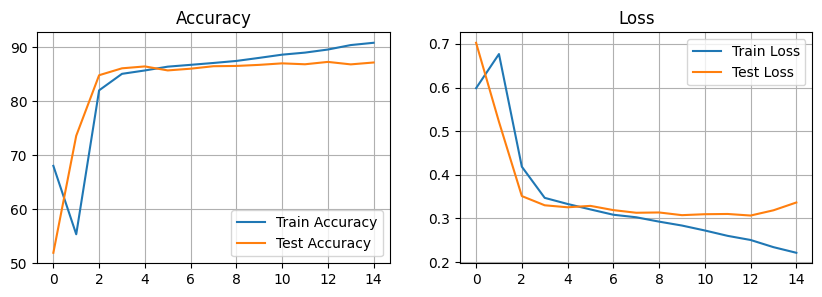

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
plt.plot(epoch_train_accs, label='Train Accuracy')
plt.plot(epoch_test_accs, label='Test Accuracy')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_losses, label='Train Loss')
plt.plot(epoch_test_losses, label='Test Loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()